In [24]:
# Importation des packaques
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing
from math import ceil,floor
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import RidgeCV,ElasticNetCV,Lasso
from sklearn.linear_model import LinearRegression,LogisticRegression
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn import model_selection
import re

In [25]:
# Importation du fichier de scraping
df = pd.read_csv('vgsales.csv')

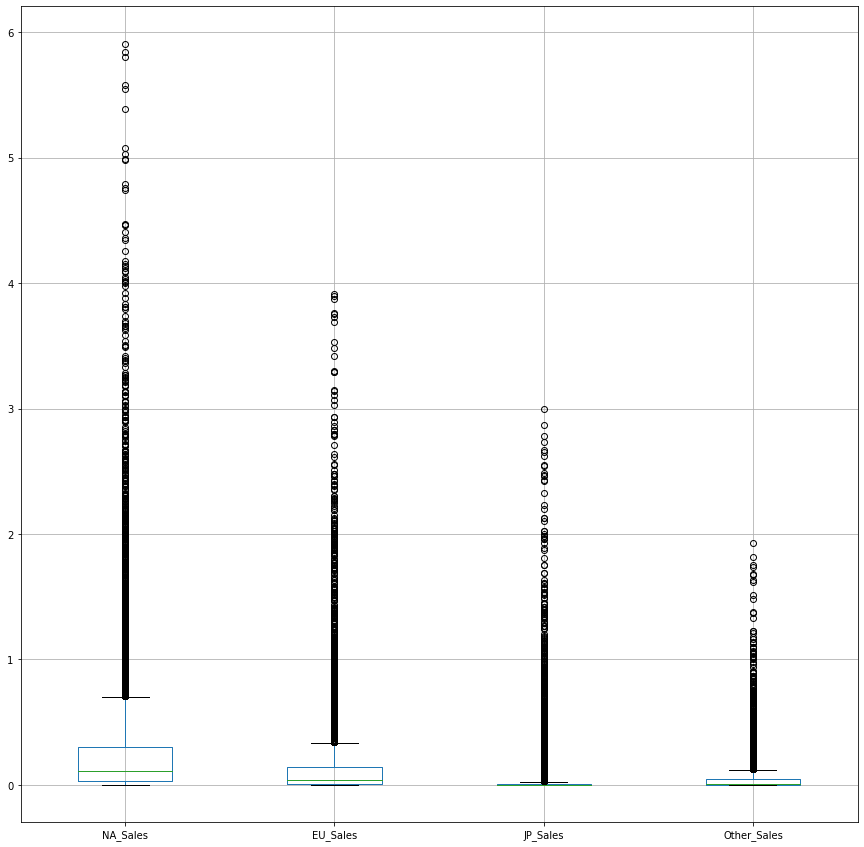

In [28]:
df.boxplot(column=['NA_Sales','EU_Sales','JP_Sales','Other_Sales'],figsize= (15,15));

In [27]:
# Suppression des outliers
df.drop(df.loc[df['NA_Sales']>6].index, inplace=True)
df.drop(df.loc[df['JP_Sales']>3].index, inplace=True)
df.drop(df.loc[df['EU_Sales']>4].index, inplace=True)
df.drop(df.loc[df['Other_Sales']>2].index, inplace=True)


In [5]:
#Suppression des lignes ou l'ensemble des ventes hors Japon sont à 0
indexNames = df[((df['NA_Sales']==0) & (df['EU_Sales']==0) & (df['Other_Sales']==0))].index
df.drop(indexNames , inplace=True)
df=df.fillna(0)

In [6]:
# Création d'un indicateur donnant un poids numérique à la série
tabserie=pd.DataFrame(df.groupby('serie')['serie'].count())
def categorize_serie(df):
    if(df['serie']==0):
        return 0
    else:
        return tabserie['serie'][df['serie']]
df['serie']=df['serie'].fillna(0)
df['SerieWeight']=df.apply(categorize_serie,axis=1)

In [7]:
#arrondi du nombre de vente au demi supérieur afin de limiter le nombre de target
#et multiplication par 10 pour que les targets soient entiers
def arrondi_05(x):
    y=floor(x)
    z=x-y
    if z==0:
        return y*10
    elif z<0.5:
        return (y+0.5)*10
    else:
        return (y+1)*10
df['NA_Sales']=df['NA_Sales'].apply(arrondi_05)
df['EU_Sales']=df['EU_Sales'].apply(arrondi_05)
df['JP_Sales']=df['JP_Sales'].apply(arrondi_05)
df['Other_Sales']=df['Other_Sales'].apply(arrondi_05)

In [8]:
df.drop(['Rank','serie','Name','gamename','samename','metaNoteQ','Global_Sales'], axis=1, inplace=True)

In [9]:
df2 = pd.get_dummies(df)
target = df2['EU_Sales']
data = df2.drop(['EU_Sales'], axis=1, inplace=False)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=66)

In [11]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

TEST REGRESSION logistique

In [14]:
# Test clf = linear_model.LogisticRegression()
#Test sur données brutes
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
print('score train :', clf.score(X_train, y_train))
print('score test :', clf.score(X_test, y_test))


score train : 0.7351307567692664
score test : 0.7408607126330402


C:\Users\Laurent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
#Test sur données recalibrées
clf2 = linear_model.LogisticRegression(solver ='newton-cg',C=10)
clf2.fit(X_train_scaled, y_train)
clf2.score(X_test_scaled, y_test)
print('score train :', clf2.score(X_train_scaled, y_train))
print('score test :', clf2.score(X_test_scaled, y_test))

score train : 0.8193705160842397
score test : 0.8111985192040722


In [19]:
# Recherche des meilleurs hyperparametres
clf_lr = LogisticRegression(max_iter=300)
params_lr = {'solver': ['liblinear', 'lbfgs','newton-cg','sag'], 'C': [10**(i) for i in range(-4, 3)]}
#params_lr = {'solver': ['newton-cg'], 'C': [10**(i) for i in range(-2, 2)]}

gridcv = GridSearchCV(clf_lr, param_grid=params_lr, scoring='accuracy', cv=3) 

In [20]:
gridcv.fit(X_train_scaled, y_train)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

C:\Users\Laurent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Laurent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Laurent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Laurent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Laurent\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached 

,params,mean_test_score,std_test_score
0,"{'C': 0.0001, 'solver': 'liblinear'}",0.757464,0.003872
1,"{'C': 0.0001, 'solver': 'lbfgs'}",0.728535,0.000044
2,"{'C': 0.0001, 'solver': 'newton-cg'}",0.728535,0.000044
3,"{'C': 0.0001, 'solver': 'sag'}",0.728535,0.000044
4,"{'C': 0.001, 'solver': 'liblinear'}",0.775978,0.000428
5,"{'C': 0.001, 'solver': 'lbfgs'}",0.774705,0.004169
6,"{'C': 0.001, 'solver': 'newton-cg'}",0.774705,0.004169
7,"{'C': 0.001, 'solver': 'sag'}",0.774705,0.004169
8,"{'C': 0.01, 'solver': 'liblinear'}",0.782574,0.001854
9,"{'C': 0.01, 'solver': 'lbfgs'}",0.786855,0.001104


RGRESSION LINERAIRE SIMPLE

In [145]:
# Insérez votre code ici 
lr = LinearRegression()
sfm = SelectFromModel(lr)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
sfm_train = sfm.fit_transform(X_train_scaled, y_train)
sfm_test = sfm.transform(X_test_scaled)

In [146]:
#Colonnes utilisées 
data.columns[sfm.get_support()]

Index(['Platform_2600', 'Platform_3DS', 'Platform_DS', 'Platform_GB',
       'Platform_GBA', 'Platform_GC', 'Platform_GEN', 'Platform_N64',
       'Platform_NES', 'Platform_PC', 'Platform_PS', 'Platform_PS2',
       'Platform_PS3', 'Platform_PS4', 'Platform_PSP', 'Platform_PSV',
       'Platform_SNES', 'Platform_Wii', 'Platform_WiiU', 'Platform_X360',
       'Platform_XB', 'Platform_XOne', 'Genre_Action', 'Genre_Adventure',
       'Genre_Fighting', 'Genre_Misc', 'Genre_Platform', 'Genre_Puzzle',
       'Genre_Racing', 'Genre_Role-Playing', 'Genre_Shooter',
       'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy',
       'Publisher_505 Games', 'Publisher_Acclaim Entertainment',
       'Publisher_Activision', 'Publisher_Adeline Software',
       'Publisher_Asmik Ace Entertainment', 'Publisher_Atari',
       'Publisher_Big Fish Games', 'Publisher_Bomb', 'Publisher_Capcom',
       'Publisher_ChunSoft', 'Publisher_Codemasters', 'Publisher_Deep Silver',
       'Publisher_Devolver Digital'

In [147]:
sfmlr = LinearRegression()
sfmlr.fit(sfm_train, y_train)

print(sfmlr.score(sfm_train, y_train))
print(sfmlr.score(sfm_test, y_test))
print('Completement dans les choux')

0.15435007019523694
-2.9589695356365867e+22
Completement dans les choux


TEST METHODE RIDGE

In [148]:
#Données brutes
ridge_reg = RidgeCV()
ridge_reg.fit(X_train, y_train)
print('alpha sélectionné par c-v :', ridge_reg.alpha_)
print('score train :', ridge_reg.score(X_train, y_train))
print('score test :', ridge_reg.score(X_test, y_test))

alpha sélectionné par c-v : 1.0
score train : 0.4951991561685555
score test : 0.423322750605431


In [149]:
#Données recalibrées
ridge_reg.fit(X_train_scaled, y_train)
print('score train :', ridge_reg.score(X_train_scaled, y_train))
print('score test :', ridge_reg.score(X_test_scaled, y_test))

score train : 0.4985273231355375
score test : 0.42069168255287326


TEST METHODE LASSO

In [151]:
lasso_r = Lasso()


In [152]:
#Données brutes
lasso_r.fit(X_train, y_train)
print('score train :', lasso_r.score(X_train, y_train))
print('score test :', lasso_r.score(X_test, y_test))

score train : 0.3589424675972612
score test : 0.31438745549970604


In [153]:
#Données recalibrées
lasso_r.fit(X_train_scaled, y_train)
print('score train :', lasso_r.score(X_train_scaled, y_train))
print('score test :', lasso_r.score(X_test_scaled, y_test))

score train : 0.2343565545742312
score test : 0.21190174716126342


METHODE ELASTIC NET

In [154]:
model_en = ElasticNetCV()

In [155]:
#Données brutes
model_en.fit(X_train, y_train)
print("score train :",model_en.score(X_train, y_train))
print("score test :", model_en.score(X_test, y_test))

score train : 0.3433757953299541
score test : 0.30405015620399645


In [156]:
#Données recalibrées
model_en.fit(X_train_scaled, y_train)
print("score train :",model_en.score(X_train_scaled, y_train))
print("score test :", model_en.score(X_test_scaled, y_test))

score train : 0.4936178432465591
score test : 0.42273666809253696
